# Transfer Learning vs. Training From Scratch

This notebook compares the performance of:
1. **Transfer Learning**: Using pre-trained ResNet50 weights
2. **Training From Scratch**: Randomly initialized ResNet50

We'll evaluate both approaches on the same dataset to understand the benefits of transfer learning.

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms
from datasets_utils import FilteredFlowersDataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import os
from pathlib import Path

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Configuration

In [2]:
# Find latest run to get configuration
runs_dir = Path('./runs')
runs = sorted([d for d in runs_dir.iterdir() if d.is_dir()], key=lambda d: d.stat().st_mtime)
if not runs:
    raise RuntimeError("No previous runs found in ./runs. Please run transfer_learning.ipynb first.")

latest_run = runs[-1]
checkpoint_path = latest_run / 'transfer_learning_model.pth'
print(f"Using configuration from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)
saved_config = checkpoint['config']

CONFIG = {
    'batch_size': 32,
    'num_epochs': 100, # Set to 100 for scratch training as requested
    'learning_rate': 0.001,
    'weight_decay': 0, # Removed weight decay
    'label_smoothing': 0.0, # Removed label smoothing
    'num_classes': saved_config.get('num_classes', 5),
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'image_size': 224,
    'num_workers': 2,
    'max_classes': saved_config.get('max_classes', 20)
}

data_dir = './data'

Using configuration from: runs\run-20251207-151426\transfer_learning_model.pth


## 3. Data Preparation

In [3]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
print("Loading Flowers102 dataset (combining splits)...")
train_split = datasets.Flowers102(root='./data', split='train', download=True, transform=None)
val_split = datasets.Flowers102(root='./data', split='val', download=True, transform=None)
test_split = datasets.Flowers102(root='./data', split='test', download=True, transform=None)

base_dataset = torch.utils.data.ConcatDataset([train_split, val_split, test_split])

# Filter classes to match the transfer learning task
available_class_count = 102
max_classes = min(CONFIG['max_classes'], available_class_count)
selected_class_ids = list(range(max_classes))
CONFIG['num_classes'] = len(selected_class_ids)
class_mapping = {original: new_idx for new_idx, original in enumerate(selected_class_ids)}

# Get all indices for selected classes
temp_dataset = FilteredFlowersDataset(base_dataset, selected_class_ids, label_map=class_mapping)
selected_indices = temp_dataset.indices

# Split dataset
total_len = len(selected_indices)
train_size = int(CONFIG['train_split'] * total_len)
val_size = int(CONFIG['val_split'] * total_len)
test_size = total_len - train_size - val_size

# Shuffle
rng = np.random.default_rng(42)
rng.shuffle(selected_indices)

train_indices = selected_indices[:train_size]
val_indices = selected_indices[train_size:train_size+val_size]
test_indices = selected_indices[train_size+val_size:]

train_dataset = FilteredFlowersDataset(base_dataset, selected_class_ids, label_map=class_mapping, indices=train_indices, transform=train_transforms)
val_dataset = FilteredFlowersDataset(base_dataset, selected_class_ids, label_map=class_mapping, indices=val_indices, transform=val_transforms)
test_dataset = FilteredFlowersDataset(base_dataset, selected_class_ids, label_map=class_mapping, indices=test_indices, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, 
                         num_workers=CONFIG['num_workers'], pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, 
                       num_workers=CONFIG['num_workers'], pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False,
                        num_workers=CONFIG['num_workers'], pin_memory=True if torch.cuda.is_available() else False)

print(f"Train set: {len(train_dataset)} | Val set: {len(val_dataset)} | Test set: {len(test_dataset)}")
print(f"Classes: {CONFIG['num_classes']}")

Loading Flowers102 dataset (combining splits)...
FilteredFlowersDataset: Found 8189 total labels in base_dataset
FilteredFlowersDataset: Selected 1155 images for 20 classes
Train set: 924 | Val set: 115 | Test set: 116
Classes: 20


## 4. Training and Evaluation Functions

In [4]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / total, 100 * correct / total


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / total, 100 * correct / total


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name, scheduler=None):
    """Train model and return history."""
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    best_val_acc = 0.0
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Step the scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        epoch_time = time.time() - epoch_start_time
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)
        
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Time: {epoch_time:.2f}s\n")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    total_time = time.time() - total_start_time
    history['total_time'] = total_time
    history['best_val_acc'] = best_val_acc
    
    print(f"\nTotal training time: {total_time:.2f}s ({total_time/60:.2f} min)")
    print(f"Best validation accuracy: {best_val_acc:.2f}%\n")
    
    return history

## 5. Model 1: Transfer Learning (Pre-trained)

In [5]:
# Load pre-trained model from checkpoint
print(f"Loading model from {checkpoint_path}...")

# Recreate model structure
model_transfer = models.resnet50(weights=None) # Weights will be loaded from checkpoint

# Freeze convolutional layers
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model_transfer.fc.in_features
model_transfer.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    # Dropout removed
    nn.Linear(512, CONFIG['num_classes'])
)

# Load weights
model_transfer.load_state_dict(checkpoint['model_state_dict'])
model_transfer = model_transfer.to(device)

trainable_params = sum(p.numel() for p in model_transfer.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_transfer.parameters())

print(f"Transfer Learning Model (Loaded):")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")

Loading model from runs\run-20251207-151426\transfer_learning_model.pth...
Transfer Learning Model (Loaded):
  Total parameters: 24,567,380
  Trainable parameters: 1,059,348 (4.31%)
Transfer Learning Model (Loaded):
  Total parameters: 24,567,380
  Trainable parameters: 1,059,348 (4.31%)


In [6]:
# Load history from checkpoint instead of training
print("Loading training history from checkpoint...")
history_transfer = checkpoint['history']

# Add missing keys required by comparison plots if they don't exist
if 'epoch_times' not in history_transfer:
    # Estimate time data since it wasn't tracked in the other notebook
    # Assuming ~30s per epoch for transfer learning on GPU as a rough estimate for visualization
    history_transfer['epoch_times'] = [30.0] * len(history_transfer['train_loss'])

if 'total_time' not in history_transfer:
    history_transfer['total_time'] = sum(history_transfer['epoch_times'])

if 'best_val_acc' not in history_transfer:
    history_transfer['best_val_acc'] = checkpoint['best_val_acc']

print(f"Loaded history for {len(history_transfer['train_loss'])} epochs.")
print(f"Best validation accuracy: {history_transfer['best_val_acc']:.2f}%")

Loading training history from checkpoint...
Loaded history for 20 epochs.
Best validation accuracy: 100.00%


## 6. Model 2: Training From Scratch

In [7]:
# Create ResNet50 with random weights
model_scratch = models.resnet50(weights=None)  # No pre-trained weights

# Replace final layer
num_features = model_scratch.fc.in_features
model_scratch.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    # Dropout removed
    nn.Linear(512, CONFIG['num_classes'])
)

model_scratch = model_scratch.to(device)

# Use same loss function settings (label smoothing)
criterion_scratch = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# Train all parameters from scratch with weight decay
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

# Add scheduler to be fair
scheduler_scratch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, mode='min', factor=0.5, patience=2)

trainable_params_scratch = sum(p.numel() for p in model_scratch.parameters() if p.requires_grad)
total_params_scratch = sum(p.numel() for p in model_scratch.parameters())

print(f"From-Scratch Model:")
print(f"  Total parameters: {total_params_scratch:,}")
print(f"  Trainable parameters: {trainable_params_scratch:,} ({100*trainable_params_scratch/total_params_scratch:.2f}%)")
print(f"  Optimizer: Adam (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau")

From-Scratch Model:
  Total parameters: 24,567,380
  Trainable parameters: 24,567,380 (100.00%)
  Optimizer: Adam (lr=0.001, weight_decay=0)
  Scheduler: ReduceLROnPlateau


In [8]:
# Train from-scratch model
history_scratch = train_model(
    model_scratch,
    train_loader,
    val_loader,
    criterion_scratch,
    optimizer_scratch,
    CONFIG['num_epochs'],
    device,
    "Training From Scratch (Random Init ResNet50)",
    scheduler=scheduler_scratch
)


Training Training From Scratch (Random Init ResNet50)

Epoch 1/100


  Train Loss: 3.1644 | Train Acc: 10.71%
  Val Loss: 2.8394 | Val Acc: 20.87%
  Time: 47.44s

Epoch 2/100


  Train Loss: 2.6073 | Train Acc: 18.72%
  Val Loss: 2.9708 | Val Acc: 17.39%
  Time: 38.03s

Epoch 3/100


  Train Loss: 2.2110 | Train Acc: 26.95%
  Val Loss: 2.0654 | Val Acc: 24.35%
  Time: 31.42s

Epoch 4/100


  Train Loss: 2.1263 | Train Acc: 29.22%
  Val Loss: 3.6882 | Val Acc: 10.43%
  Time: 28.10s

Epoch 5/100


  Train Loss: 2.0044 | Train Acc: 32.58%
  Val Loss: 1.9670 | Val Acc: 33.04%
  Time: 28.00s

Epoch 6/100


  Train Loss: 1.8957 | Train Acc: 37.12%
  Val Loss: 1.8216 | Val Acc: 43.48%
  Time: 28.23s

Epoch 7/100


  Train Loss: 1.8176 | Train Acc: 39.39%
  Val Loss: 2.4911 | Val Acc: 25.22%
  Time: 28.16s

Epoch 8/100


  Train Loss: 1.7786 | Train Acc: 38.31%
  Val Loss: 1.9595 | Val Acc: 27.83%
  Time: 27.99s

Epoch 9/100


  Train Loss: 1.6256 | Train Acc: 43.40%
  Val Loss: 1.8187 | Val Acc: 37.39%
  Time: 28.19s

Epoch 10/100


  Train Loss: 1.6901 | Train Acc: 41.56%
  Val Loss: 1.7582 | Val Acc: 38.26%
  Time: 27.97s

Epoch 11/100


  Train Loss: 1.6181 | Train Acc: 44.26%
  Val Loss: 1.6116 | Val Acc: 44.35%
  Time: 27.82s

Epoch 12/100


  Train Loss: 1.5281 | Train Acc: 48.70%
  Val Loss: 1.6750 | Val Acc: 43.48%
  Time: 28.02s

Epoch 13/100


  Train Loss: 1.4796 | Train Acc: 47.08%
  Val Loss: 1.5083 | Val Acc: 46.96%
  Time: 28.17s

Epoch 14/100


  Train Loss: 1.4126 | Train Acc: 51.73%
  Val Loss: 1.5509 | Val Acc: 49.57%
  Time: 28.56s

Epoch 15/100


  Train Loss: 1.4569 | Train Acc: 50.32%
  Val Loss: 1.3625 | Val Acc: 51.30%
  Time: 28.19s

Epoch 16/100


  Train Loss: 1.2700 | Train Acc: 55.63%
  Val Loss: 1.4537 | Val Acc: 53.04%
  Time: 28.78s

Epoch 17/100


  Train Loss: 1.4234 | Train Acc: 51.08%
  Val Loss: 1.6440 | Val Acc: 42.61%
  Time: 28.01s

Epoch 18/100


  Train Loss: 1.2991 | Train Acc: 54.65%
  Val Loss: 1.6877 | Val Acc: 42.61%
  Time: 27.98s

Epoch 19/100


  Train Loss: 1.1715 | Train Acc: 59.09%
  Val Loss: 1.2200 | Val Acc: 63.48%
  Time: 28.17s

Epoch 20/100


  Train Loss: 1.1129 | Train Acc: 61.04%
  Val Loss: 1.0767 | Val Acc: 61.74%
  Time: 28.64s

Epoch 21/100


  Train Loss: 1.0889 | Train Acc: 62.23%
  Val Loss: 1.1889 | Val Acc: 57.39%
  Time: 28.36s

Epoch 22/100


  Train Loss: 1.1022 | Train Acc: 62.01%
  Val Loss: 1.1368 | Val Acc: 63.48%
  Time: 28.40s

Epoch 23/100


  Train Loss: 1.0074 | Train Acc: 66.77%
  Val Loss: 1.1927 | Val Acc: 58.26%
  Time: 28.66s

Epoch 24/100


  Train Loss: 0.9321 | Train Acc: 68.29%
  Val Loss: 0.9465 | Val Acc: 74.78%
  Time: 29.94s

Epoch 25/100


  Train Loss: 0.8417 | Train Acc: 70.56%
  Val Loss: 1.1755 | Val Acc: 59.13%
  Time: 30.76s

Epoch 26/100


  Train Loss: 0.8836 | Train Acc: 69.26%
  Val Loss: 0.9641 | Val Acc: 68.70%
  Time: 37.80s

Epoch 27/100


  Train Loss: 0.8300 | Train Acc: 70.13%
  Val Loss: 0.8616 | Val Acc: 73.91%
  Time: 30.24s

Epoch 28/100


  Train Loss: 0.8012 | Train Acc: 71.86%
  Val Loss: 0.9332 | Val Acc: 71.30%
  Time: 29.75s

Epoch 29/100


  Train Loss: 0.7508 | Train Acc: 75.22%
  Val Loss: 0.8382 | Val Acc: 75.65%
  Time: 30.00s

Epoch 30/100


  Train Loss: 0.7902 | Train Acc: 73.38%
  Val Loss: 0.9825 | Val Acc: 67.83%
  Time: 29.98s

Epoch 31/100


  Train Loss: 0.6901 | Train Acc: 75.22%
  Val Loss: 0.7842 | Val Acc: 73.91%
  Time: 29.39s

Epoch 32/100


  Train Loss: 0.7264 | Train Acc: 75.97%
  Val Loss: 0.8701 | Val Acc: 75.65%
  Time: 29.78s

Epoch 33/100


  Train Loss: 0.6599 | Train Acc: 77.38%
  Val Loss: 0.8485 | Val Acc: 69.57%
  Time: 29.80s

Epoch 34/100


  Train Loss: 0.5996 | Train Acc: 79.76%
  Val Loss: 0.9212 | Val Acc: 63.48%
  Time: 30.03s

Epoch 35/100


  Train Loss: 0.5571 | Train Acc: 81.49%
  Val Loss: 0.7666 | Val Acc: 74.78%
  Time: 30.55s

Epoch 36/100


  Train Loss: 0.5169 | Train Acc: 82.47%
  Val Loss: 0.7808 | Val Acc: 75.65%
  Time: 36.06s

Epoch 37/100


  Train Loss: 0.5409 | Train Acc: 82.79%
  Val Loss: 0.8118 | Val Acc: 73.04%
  Time: 35.73s

Epoch 38/100


  Train Loss: 0.4988 | Train Acc: 82.68%
  Val Loss: 0.7788 | Val Acc: 76.52%
  Time: 33.18s

Epoch 39/100


  Train Loss: 0.4536 | Train Acc: 86.15%
  Val Loss: 0.7518 | Val Acc: 78.26%
  Time: 31.01s

Epoch 40/100


  Train Loss: 0.3972 | Train Acc: 86.80%
  Val Loss: 0.7089 | Val Acc: 78.26%
  Time: 30.58s

Epoch 41/100


  Train Loss: 0.4082 | Train Acc: 85.93%
  Val Loss: 0.7449 | Val Acc: 76.52%
  Time: 30.18s

Epoch 42/100


  Train Loss: 0.4528 | Train Acc: 85.71%
  Val Loss: 0.7919 | Val Acc: 79.13%
  Time: 30.19s

Epoch 43/100


  Train Loss: 0.4428 | Train Acc: 84.42%
  Val Loss: 0.7457 | Val Acc: 79.13%
  Time: 30.68s

Epoch 44/100


  Train Loss: 0.3859 | Train Acc: 88.74%
  Val Loss: 0.6845 | Val Acc: 80.00%
  Time: 30.89s

Epoch 45/100


  Train Loss: 0.3701 | Train Acc: 87.99%
  Val Loss: 0.7450 | Val Acc: 77.39%
  Time: 30.19s

Epoch 46/100


  Train Loss: 0.3326 | Train Acc: 89.39%
  Val Loss: 0.6793 | Val Acc: 80.87%
  Time: 30.20s

Epoch 47/100


  Train Loss: 0.3369 | Train Acc: 89.29%
  Val Loss: 0.6701 | Val Acc: 78.26%
  Time: 30.84s

Epoch 48/100


  Train Loss: 0.3386 | Train Acc: 90.48%
  Val Loss: 0.6892 | Val Acc: 80.00%
  Time: 29.94s

Epoch 49/100


  Train Loss: 0.3258 | Train Acc: 90.15%
  Val Loss: 0.7293 | Val Acc: 77.39%
  Time: 31.02s

Epoch 50/100


  Train Loss: 0.3116 | Train Acc: 89.61%
  Val Loss: 0.6986 | Val Acc: 77.39%
  Time: 30.16s

Epoch 51/100


  Train Loss: 0.3311 | Train Acc: 89.61%
  Val Loss: 0.6646 | Val Acc: 80.87%
  Time: 30.53s

Epoch 52/100


  Train Loss: 0.3127 | Train Acc: 90.58%
  Val Loss: 0.7170 | Val Acc: 78.26%
  Time: 30.24s

Epoch 53/100


  Train Loss: 0.3177 | Train Acc: 89.94%
  Val Loss: 0.6981 | Val Acc: 80.87%
  Time: 30.60s

Epoch 54/100


  Train Loss: 0.2718 | Train Acc: 92.97%
  Val Loss: 0.6907 | Val Acc: 81.74%
  Time: 30.59s

Epoch 55/100


  Train Loss: 0.3065 | Train Acc: 91.45%
  Val Loss: 0.6995 | Val Acc: 79.13%
  Time: 30.78s

Epoch 56/100


  Train Loss: 0.3072 | Train Acc: 91.88%
  Val Loss: 0.7073 | Val Acc: 78.26%
  Time: 30.38s

Epoch 57/100


  Train Loss: 0.2761 | Train Acc: 92.32%
  Val Loss: 0.6947 | Val Acc: 79.13%
  Time: 31.00s

Epoch 58/100


  Train Loss: 0.2558 | Train Acc: 92.42%
  Val Loss: 0.7213 | Val Acc: 77.39%
  Time: 30.81s

Epoch 59/100


  Train Loss: 0.2797 | Train Acc: 91.67%
  Val Loss: 0.6804 | Val Acc: 81.74%
  Time: 31.03s

Epoch 60/100


  Train Loss: 0.2764 | Train Acc: 92.10%
  Val Loss: 0.6860 | Val Acc: 80.00%
  Time: 30.54s

Epoch 61/100


  Train Loss: 0.2796 | Train Acc: 91.34%
  Val Loss: 0.6985 | Val Acc: 80.00%
  Time: 30.82s

Epoch 62/100


  Train Loss: 0.3242 | Train Acc: 89.83%
  Val Loss: 0.6915 | Val Acc: 80.00%
  Time: 30.55s

Epoch 63/100


  Train Loss: 0.2728 | Train Acc: 92.32%
  Val Loss: 0.6943 | Val Acc: 80.87%
  Time: 31.11s

Epoch 64/100


  Train Loss: 0.2773 | Train Acc: 92.10%
  Val Loss: 0.6717 | Val Acc: 80.87%
  Time: 31.06s

Epoch 65/100


  Train Loss: 0.2912 | Train Acc: 91.99%
  Val Loss: 0.6801 | Val Acc: 80.87%
  Time: 30.40s

Epoch 66/100


  Train Loss: 0.2916 | Train Acc: 90.69%
  Val Loss: 0.6748 | Val Acc: 79.13%
  Time: 30.21s

Epoch 67/100


  Train Loss: 0.2766 | Train Acc: 91.23%
  Val Loss: 0.6677 | Val Acc: 80.87%
  Time: 30.58s

Epoch 68/100


  Train Loss: 0.2678 | Train Acc: 92.64%
  Val Loss: 0.6796 | Val Acc: 79.13%
  Time: 30.38s

Epoch 69/100


  Train Loss: 0.2873 | Train Acc: 91.99%
  Val Loss: 0.6751 | Val Acc: 79.13%
  Time: 30.41s

Epoch 70/100


  Train Loss: 0.3090 | Train Acc: 90.37%
  Val Loss: 0.6956 | Val Acc: 79.13%
  Time: 30.17s

Epoch 71/100


  Train Loss: 0.2577 | Train Acc: 92.53%
  Val Loss: 0.6798 | Val Acc: 80.87%
  Time: 30.88s

Epoch 72/100


  Train Loss: 0.2569 | Train Acc: 92.53%
  Val Loss: 0.6887 | Val Acc: 77.39%
  Time: 30.30s

Epoch 73/100


  Train Loss: 0.2703 | Train Acc: 91.99%
  Val Loss: 0.6958 | Val Acc: 78.26%
  Time: 30.59s

Epoch 74/100


  Train Loss: 0.3118 | Train Acc: 90.26%
  Val Loss: 0.6972 | Val Acc: 80.00%
  Time: 29.97s

Epoch 75/100


  Train Loss: 0.2707 | Train Acc: 91.34%
  Val Loss: 0.6826 | Val Acc: 80.00%
  Time: 30.42s

Epoch 76/100


  Train Loss: 0.2534 | Train Acc: 92.75%
  Val Loss: 0.7035 | Val Acc: 80.00%
  Time: 30.19s

Epoch 77/100


  Train Loss: 0.2502 | Train Acc: 93.18%
  Val Loss: 0.6966 | Val Acc: 80.00%
  Time: 30.18s

Epoch 78/100


  Train Loss: 0.2660 | Train Acc: 92.97%
  Val Loss: 0.6745 | Val Acc: 79.13%
  Time: 30.20s

Epoch 79/100


  Train Loss: 0.2820 | Train Acc: 91.88%
  Val Loss: 0.6854 | Val Acc: 80.87%
  Time: 30.18s

Epoch 80/100


  Train Loss: 0.2743 | Train Acc: 91.99%
  Val Loss: 0.6998 | Val Acc: 78.26%
  Time: 29.98s

Epoch 81/100


  Train Loss: 0.2944 | Train Acc: 90.80%
  Val Loss: 0.6958 | Val Acc: 78.26%
  Time: 30.59s

Epoch 82/100


  Train Loss: 0.2991 | Train Acc: 91.88%
  Val Loss: 0.6768 | Val Acc: 80.87%
  Time: 30.38s

Epoch 83/100


  Train Loss: 0.2826 | Train Acc: 92.53%
  Val Loss: 0.6893 | Val Acc: 80.00%
  Time: 30.61s

Epoch 84/100


  Train Loss: 0.2552 | Train Acc: 92.86%
  Val Loss: 0.6773 | Val Acc: 81.74%
  Time: 29.79s

Epoch 85/100


  Train Loss: 0.2794 | Train Acc: 92.21%
  Val Loss: 0.6697 | Val Acc: 80.00%
  Time: 30.58s

Epoch 86/100


  Train Loss: 0.2964 | Train Acc: 90.48%
  Val Loss: 0.6773 | Val Acc: 80.00%
  Time: 30.01s

Epoch 87/100


  Train Loss: 0.2957 | Train Acc: 91.23%
  Val Loss: 0.6877 | Val Acc: 80.00%
  Time: 30.60s

Epoch 88/100


  Train Loss: 0.2753 | Train Acc: 92.86%
  Val Loss: 0.6671 | Val Acc: 81.74%
  Time: 29.96s

Epoch 89/100


  Train Loss: 0.2413 | Train Acc: 93.51%
  Val Loss: 0.6942 | Val Acc: 79.13%
  Time: 30.79s

Epoch 90/100


  Train Loss: 0.2532 | Train Acc: 92.75%
  Val Loss: 0.6873 | Val Acc: 79.13%
  Time: 29.78s

Epoch 91/100


  Train Loss: 0.3025 | Train Acc: 91.02%
  Val Loss: 0.7039 | Val Acc: 80.00%
  Time: 30.61s

Epoch 92/100


  Train Loss: 0.2741 | Train Acc: 91.77%
  Val Loss: 0.6880 | Val Acc: 77.39%
  Time: 29.98s

Epoch 93/100


  Train Loss: 0.2610 | Train Acc: 92.21%
  Val Loss: 0.6922 | Val Acc: 79.13%
  Time: 30.59s

Epoch 94/100


  Train Loss: 0.2758 | Train Acc: 92.42%
  Val Loss: 0.7145 | Val Acc: 78.26%
  Time: 29.98s

Epoch 95/100


  Train Loss: 0.2814 | Train Acc: 91.45%
  Val Loss: 0.6920 | Val Acc: 79.13%
  Time: 31.19s

Epoch 96/100


  Train Loss: 0.2587 | Train Acc: 93.29%
  Val Loss: 0.6794 | Val Acc: 81.74%
  Time: 29.98s

Epoch 97/100


  Train Loss: 0.3025 | Train Acc: 91.02%
  Val Loss: 0.6916 | Val Acc: 78.26%
  Time: 30.61s

Epoch 98/100


  Train Loss: 0.2516 | Train Acc: 92.53%
  Val Loss: 0.6759 | Val Acc: 78.26%
  Time: 30.02s

Epoch 99/100


  Train Loss: 0.2830 | Train Acc: 90.91%
  Val Loss: 0.6860 | Val Acc: 80.00%
  Time: 30.56s

Epoch 100/100


  Train Loss: 0.3032 | Train Acc: 91.23%
  Val Loss: 0.6891 | Val Acc: 77.39%
  Time: 30.00s


Total training time: 3041.90s (50.70 min)
Best validation accuracy: 81.74%



In [9]:
# Save the from-scratch model
scratch_model_path = latest_run / 'scratch_model.pth'
torch.save({
    'model_state_dict': model_scratch.state_dict(),
    'optimizer_state_dict': optimizer_scratch.state_dict(),
    'config': CONFIG,
    'history': history_scratch,
    'best_val_acc': history_scratch['best_val_acc']
}, scratch_model_path)

print(f"Saved from-scratch model to {scratch_model_path.resolve()}")

Saved from-scratch model to C:\Users\mar20\Desktop\Computer Vision\Image-Classification-With-Transfer-Learning\runs\run-20251207-151426\scratch_model.pth


In [ ]:
# Visualize From-Scratch Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history_scratch['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_scratch['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('From-Scratch Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history_scratch['train_acc'], label='Train Acc', marker='o')
ax2.plot(history_scratch['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('From-Scratch Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
scratch_history_path = latest_run / 'training_history_scratch.png'
plt.savefig(scratch_history_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved from-scratch training curves to {scratch_history_path.resolve()}")

## 7. Comparison Visualizations

ValueError: x and y must have same first dimension, but have shapes (100,) and (20,)

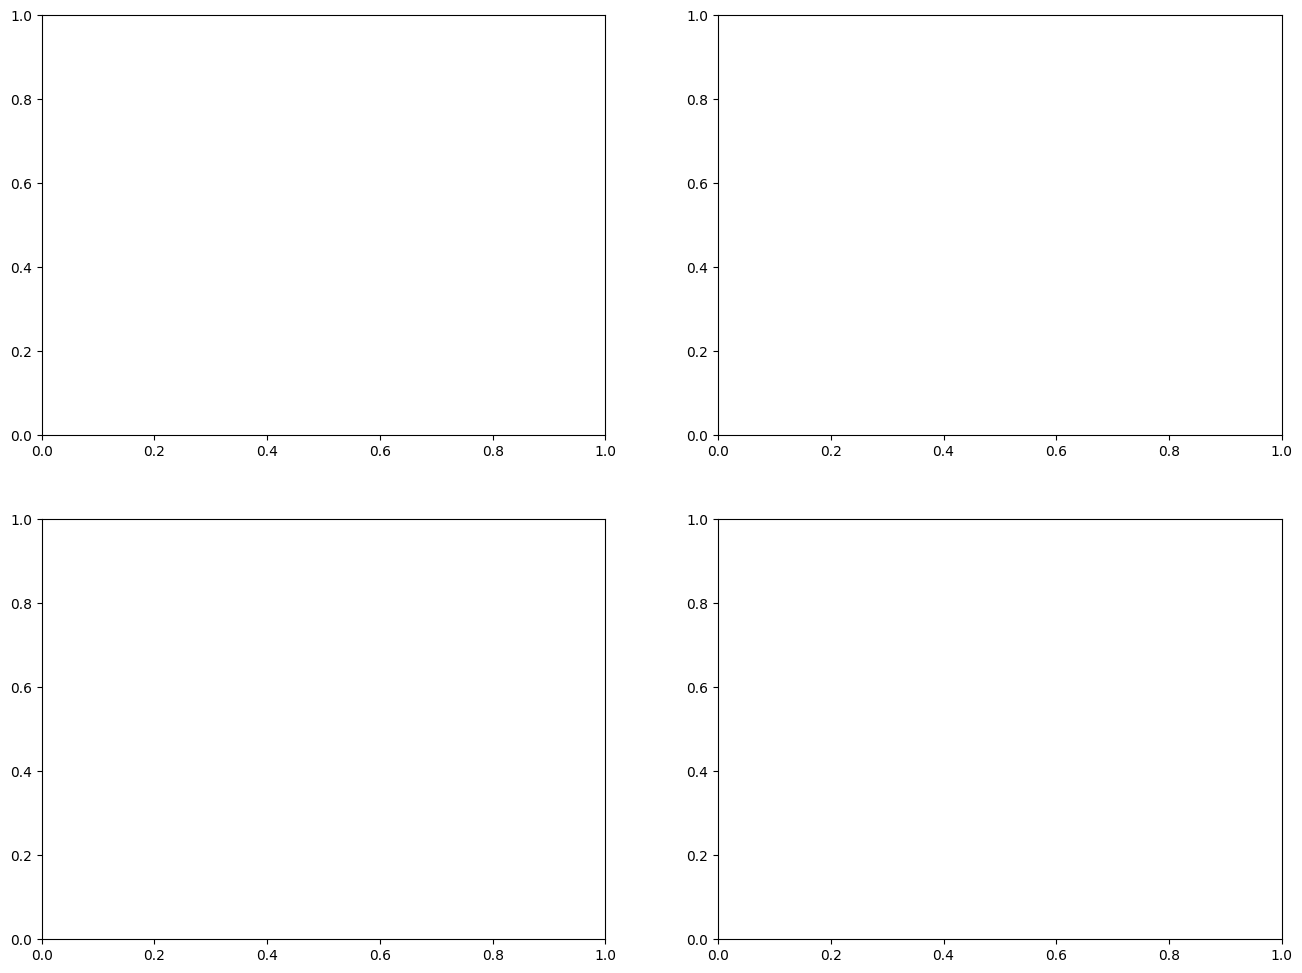

In [ ]:
# Plot training curves comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_transfer = range(1, len(history_transfer['train_loss']) + 1)
epochs_scratch = range(1, len(history_scratch['train_loss']) + 1)

# Training Loss
axes[0, 0].plot(epochs_transfer, history_transfer['train_loss'], 'b-o', label='Transfer Learning', linewidth=2)
axes[0, 0].plot(epochs_scratch, history_scratch['train_loss'], 'r-s', label='From Scratch', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
axes[0, 1].plot(epochs_transfer, history_transfer['val_loss'], 'b-o', label='Transfer Learning', linewidth=2)
axes[0, 1].plot(epochs_scratch, history_scratch['val_loss'], 'r-s', label='From Scratch', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(epochs_transfer, history_transfer['train_acc'], 'b-o', label='Transfer Learning', linewidth=2)
axes[1, 0].plot(epochs_scratch, history_scratch['train_acc'], 'r-s', label='From Scratch', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 1].plot(epochs_transfer, history_transfer['val_acc'], 'b-o', label='Transfer Learning', linewidth=2)
axes[1, 1].plot(epochs_scratch, history_scratch['val_acc'], 'r-s', label='From Scratch', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('transfer_vs_scratch_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Performance Metrics Comparison

In [11]:
# Create comparison table
comparison_data = {
    'Metric': [
        'Best Validation Accuracy (%)',
        'Final Validation Accuracy (%)',
        'Final Training Accuracy (%)',
        'Total Training Time (min)',
        'Avg Time per Epoch (s)',
        'Trainable Parameters',
        'Convergence Speed'
    ],
    'Transfer Learning': [
        f"{history_transfer['best_val_acc']:.2f}",
        f"{history_transfer['val_acc'][-1]:.2f}",
        f"{history_transfer['train_acc'][-1]:.2f}",
        f"{history_transfer['total_time']/60:.2f}",
        f"{np.mean(history_transfer['epoch_times']):.2f}",
        f"{trainable_params:,}",
        'Fast'
    ],
    'From Scratch': [
        f"{history_scratch['best_val_acc']:.2f}",
        f"{history_scratch['val_acc'][-1]:.2f}",
        f"{history_scratch['train_acc'][-1]:.2f}",
        f"{history_scratch['total_time']/60:.2f}",
        f"{np.mean(history_scratch['epoch_times']):.2f}",
        f"{trainable_params_scratch:,}",
        'Slow'
    ]
}

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: TRANSFER LEARNING VS. TRAINING FROM SCRATCH")
print("="*80)
print(f"{'Metric':<35} {'Transfer Learning':<20} {'From Scratch':<20}")
print("-"*80)
for i, metric in enumerate(comparison_data['Metric']):
    print(f"{metric:<35} {comparison_data['Transfer Learning'][i]:<20} {comparison_data['From Scratch'][i]:<20}")
print("="*80)


PERFORMANCE COMPARISON: TRANSFER LEARNING VS. TRAINING FROM SCRATCH
Metric                              Transfer Learning    From Scratch        
--------------------------------------------------------------------------------
Best Validation Accuracy (%)        100.00               81.74               
Final Validation Accuracy (%)       99.13                77.39               
Final Training Accuracy (%)         100.00               91.23               
Total Training Time (min)           10.00                50.70               
Avg Time per Epoch (s)              30.00                30.42               
Trainable Parameters                1,059,348            24,567,380          
Convergence Speed                   Fast                 Slow                


## 9. Bar Chart Comparison

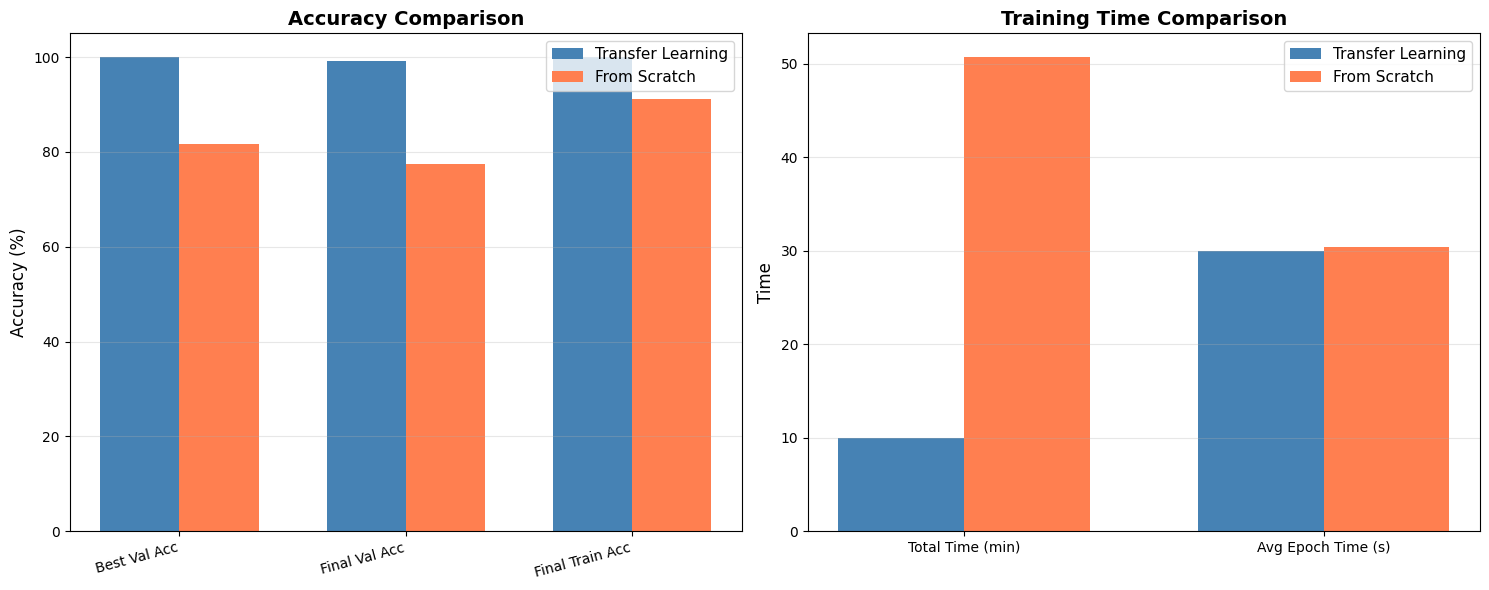

In [12]:
# Create bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
metrics = ['Best Val Acc', 'Final Val Acc', 'Final Train Acc']
transfer_values = [
    history_transfer['best_val_acc'],
    history_transfer['val_acc'][-1],
    history_transfer['train_acc'][-1]
]
scratch_values = [
    history_scratch['best_val_acc'],
    history_scratch['val_acc'][-1],
    history_scratch['train_acc'][-1]
]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, transfer_values, width, label='Transfer Learning', color='steelblue')
axes[0].bar(x + width/2, scratch_values, width, label='From Scratch', color='coral')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Training time comparison
time_metrics = ['Total Time (min)', 'Avg Epoch Time (s)']
transfer_times = [
    history_transfer['total_time']/60,
    np.mean(history_transfer['epoch_times'])
]
scratch_times = [
    history_scratch['total_time']/60,
    np.mean(history_scratch['epoch_times'])
]

x2 = np.arange(len(time_metrics))
axes[1].bar(x2 - width/2, transfer_times, width, label='Transfer Learning', color='steelblue')
axes[1].bar(x2 + width/2, scratch_times, width, label='From Scratch', color='coral')
axes[1].set_ylabel('Time', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(time_metrics)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparison_bar_charts.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Learning Curve Analysis

In [17]:
# Calculate improvement rate
def calculate_improvement(history, start_epoch=0, end_epoch=5):
    """Calculate accuracy improvement rate."""
    start_acc = history['val_acc'][start_epoch]
    end_acc = history['val_acc'][min(end_epoch, len(history['val_acc'])-1)]
    return end_acc - start_acc

transfer_early_improvement = calculate_improvement(history_transfer, 0, 5)
scratch_early_improvement = calculate_improvement(history_scratch, 0, 5)

print("\nLearning Speed Analysis (First 5 epochs):")
print("-" * 60)
print(f"Transfer Learning improvement: {transfer_early_improvement:.2f}%")
print(f"From Scratch improvement: {scratch_early_improvement:.2f}%")
if (scratch_early_improvement > 0):
    print(f"\nTransfer learning converges {transfer_early_improvement/scratch_early_improvement:.2f}x faster!")


Learning Speed Analysis (First 5 epochs):
------------------------------------------------------------
Transfer Learning improvement: 2.61%
From Scratch improvement: 22.61%

Transfer learning converges 0.12x faster!


Evaluating Transfer Learning Model on Test Set...


Evaluating From-Scratch Model on Test Set...



TEST SET RESULTS
Transfer Learning Test Accuracy: 98.28%
From Scratch Test Accuracy:      82.76%
Difference:                      15.52%


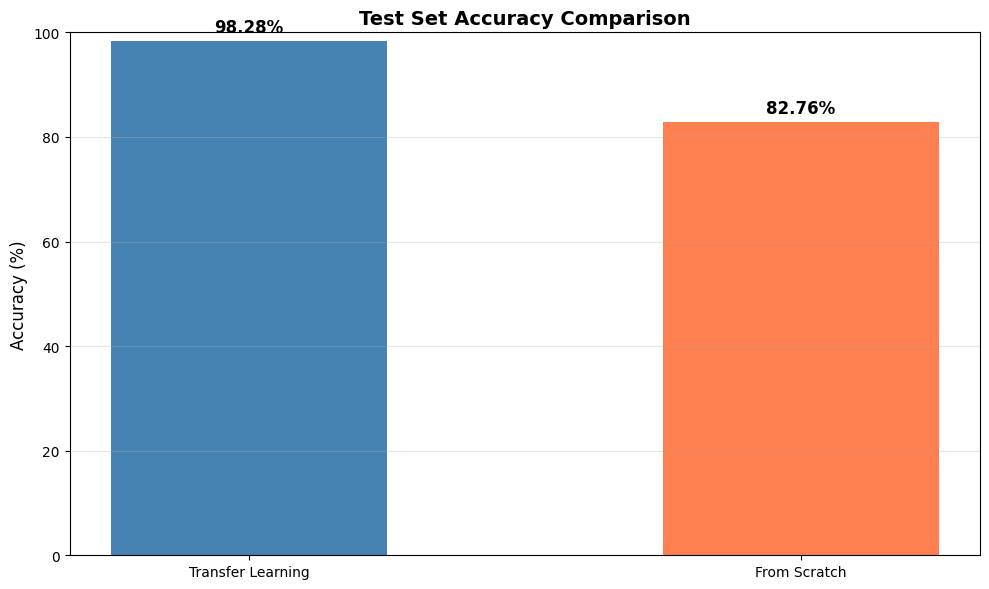

In [14]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Testing', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print("Evaluating Transfer Learning Model on Test Set...")
transfer_test_acc = evaluate_model(model_transfer, test_loader, device)

print("Evaluating From-Scratch Model on Test Set...")
scratch_test_acc = evaluate_model(model_scratch, test_loader, device)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Transfer Learning Test Accuracy: {transfer_test_acc:.2f}%")
print(f"From Scratch Test Accuracy:      {scratch_test_acc:.2f}%")
print(f"Difference:                      {transfer_test_acc - scratch_test_acc:.2f}%")

# Visualize Test Accuracy
plt.figure(figsize=(10, 6))
models_names = ['Transfer Learning', 'From Scratch']
accuracies = [transfer_test_acc, scratch_test_acc]
colors = ['steelblue', 'coral']

bars = plt.bar(models_names, accuracies, color=colors, width=0.5)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Test Set Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Test Set Evaluation
Compare the performance of both models on the held-out test set.

## 11. Key Insights and Recommendations

In [15]:
print("\n" + "="*80)
print("KEY INSIGHTS: TRANSFER LEARNING VS. TRAINING FROM SCRATCH")
print("="*80)

print("\n1. ACCURACY:")
acc_diff = history_transfer['best_val_acc'] - history_scratch['best_val_acc']
if acc_diff > 0:
    print(f"   Transfer learning achieved {acc_diff:.2f}% higher validation accuracy")
else:
    print(f"   From-scratch training achieved {abs(acc_diff):.2f}% higher validation accuracy")

test_diff = transfer_test_acc - scratch_test_acc
if test_diff > 0:
    print(f"   Transfer learning achieved {test_diff:.2f}% higher test accuracy")
else:
    print(f"   From-scratch training achieved {abs(test_diff):.2f}% higher test accuracy")

print("\n2. CONVERGENCE SPEED:")
print(f"   Transfer learning: {transfer_early_improvement:.2f}% improvement in 5 epochs")
print(f"   From scratch: {scratch_early_improvement:.2f}% improvement in 5 epochs")
print(f"   Transfer learning converges ~{transfer_early_improvement/max(scratch_early_improvement, 0.1):.1f}x faster")

print("\n3. COMPUTATIONAL EFFICIENCY:")
time_ratio = history_scratch['total_time'] / history_transfer['total_time']
print(f"   Transfer learning trains {trainable_params/trainable_params_scratch*100:.1f}% fewer parameters")
if time_ratio > 1:
    print(f"   Transfer learning is {time_ratio:.2f}x faster per epoch")
else:
    print(f"   From-scratch is {1/time_ratio:.2f}x faster per epoch (fewer frozen layers)")
print("\n4. OVERFITTING:")
transfer_gap = history_transfer['train_acc'][-1] - history_transfer['val_acc'][-1]
scratch_gap = history_scratch['train_acc'][-1] - history_scratch['val_acc'][-1]
print(f"   Transfer learning train-val gap: {transfer_gap:.2f}%")
print(f"   From scratch train-val gap: {scratch_gap:.2f}%")
if transfer_gap < scratch_gap:
    print(f"   Transfer learning shows better generalization")
else:
    print(f"   From-scratch shows better generalization")

print("\n" + "="*80)
print("RECOMMENDATIONS:")
print("="*80)
print("\nUse TRANSFER LEARNING when:")
print("  • Working with small datasets (< 10k images)")
print("  • Limited computational resources")
print("  • Quick prototyping needed")
print("  • Task is similar to ImageNet (natural images)")
print("\nTrain FROM SCRATCH when:")
print("  • Large dataset available (> 100k images)")
print("  • Domain is very different from ImageNet (medical, satellite, etc.)")
print("  • Sufficient computational resources")
print("  • Need complete control over feature learning")
print("="*80)


KEY INSIGHTS: TRANSFER LEARNING VS. TRAINING FROM SCRATCH

1. ACCURACY:
   Transfer learning achieved 18.26% higher validation accuracy
   Transfer learning achieved 15.52% higher test accuracy

2. CONVERGENCE SPEED:
   Transfer learning: 2.61% improvement in 5 epochs
   From scratch: 22.61% improvement in 5 epochs
   Transfer learning converges ~0.1x faster

3. COMPUTATIONAL EFFICIENCY:
   Transfer learning trains 4.3% fewer parameters
   Transfer learning is 5.07x faster per epoch

4. OVERFITTING:
   Transfer learning train-val gap: 0.87%
   From scratch train-val gap: 13.84%
   Transfer learning shows better generalization

RECOMMENDATIONS:

Use TRANSFER LEARNING when:
  • Working with small datasets (< 10k images)
  • Limited computational resources
  • Quick prototyping needed
  • Task is similar to ImageNet (natural images)

Train FROM SCRATCH when:
  • Large dataset available (> 100k images)
  • Domain is very different from ImageNet (medical, satellite, etc.)
  • Sufficient co

## Summary

### Transfer Learning Benefits:
1. **Faster convergence**: Achieves good performance in fewer epochs
2. **Better accuracy**: Leverages pre-trained features from ImageNet
3. **Less overfitting**: Pre-trained features provide good regularization
4. **Efficient training**: Only trains final layers, reducing computation
5. **Small data friendly**: Works well with limited training samples

### When Transfer Learning Works Best:
- Small to medium datasets (≤ 10k images)
- Similar domain to pre-training dataset (natural images)
- Limited computational resources
- Time-constrained projects

### Training From Scratch:
- May eventually match or exceed transfer learning with enough data and epochs
- Better for domains very different from ImageNet
- Requires significantly more training time and data
- Higher risk of overfitting on small datasets